# Map-based simulation for differential gain

## Here, we introduce how to assess differential gain systematics by the map-based simulation in the case of a single detector on the boresight.


In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scanfields import Field, ScanFields, SignalFields

# Load the cross-link on the boresight detector

## Input map: CMB (r=0), No Gaussian beam smoothing


In [2]:
# Load single detector map
base_path = "../crosslinks_2407_3yr/boresight"
scan_field = ScanFields.load_det(base_path, "nside128_boresight.h5")
input_map = hp.read_map("./cmb_0000_nside_128_seed_33.fits", field=(0,1,2)) * 1e6

# Set a differential gain parameter

`g_a`: a gain of `detector-A` $\to g^A$

`g_b`: a gain of `detector-B`, which constructs orthgonal pair with `detector-A` $\to g^B$

Here, we set `1%` differential gain


In [3]:
g_a = 0.01
g_b = 0.0
delta_g = g_a - g_b
I = input_map[0]
P = input_map[1] + 1j*input_map[2]

signal_field = SignalFields(
    Field(delta_g*I/2, spin=0),
    Field((2.0+g_a+g_b)*P/4, spin=2),
    Field((2.0+g_a+g_b)*P.conj()/4, spin=-2),
)

In [4]:
# Make total detected sygnal by coupling cross-links and signal fields
s_0 = scan_field.couple(signal_field, spin_out=0)
sp2 = scan_field.couple(signal_field, spin_out=2)
sm2 = scan_field.couple(signal_field, spin_out=-2)

# Solve the liner system

Detailed discription coming soon...


In [5]:
output_map = scan_field.map_make(signal_field, mdim=2)
residual = input_map - output_map

# Let's check the Input/Output/Residual maps

Especially, we can see that the residual map (Q and U) which is reconstructed by 2D noise covariant matrix are contaminated by the gain offset.


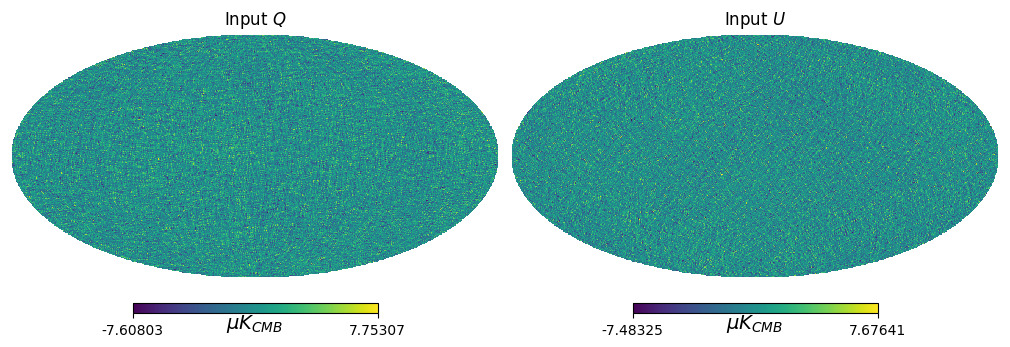

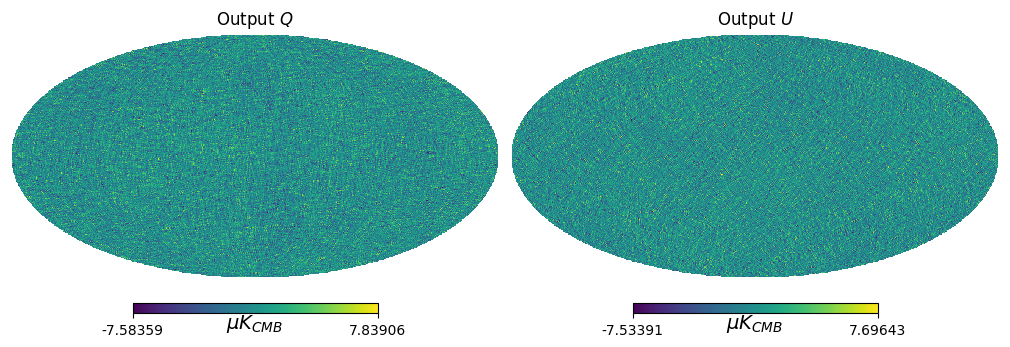

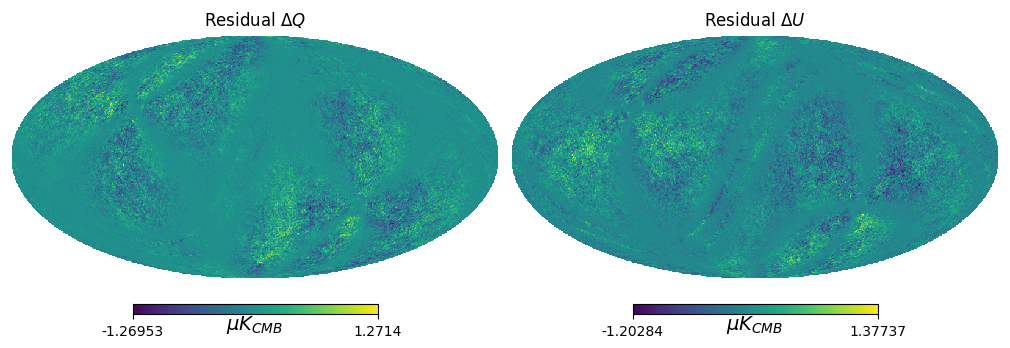

In [6]:
plt.figure(figsize=(10,5))
hp.mollview(input_map[1], sub=(1,2,1), title="Input $Q$", unit="$\mu K_{CMB}$")
hp.mollview(input_map[2], sub=(1,2,2), title="Input $U$", unit="$\mu K_{CMB}$")

plt.figure(figsize=(10,5))
hp.mollview(output_map[1], sub=(1,2,1), title="Output $Q$", unit="$\mu K_{CMB}$")
hp.mollview(output_map[2], sub=(1,2,2), title="Output $U$", unit="$\mu K_{CMB}$")

plt.figure(figsize=(10,5))
hp.mollview(residual[1], sub=(1,2,1), title="Residual $\Delta Q$", unit="$\mu K_{CMB}$")
hp.mollview(residual[2], sub=(1,2,2), title="Residual $\Delta U$", unit="$\mu K_{CMB}$")

In [7]:
input_cl = hp.anafast(input_map)
res_cl = hp.anafast(residual)

# Let's check the power spectra

The green line shows systematics power spectrum, i.e., $\Delta C_\ell^{BB}$, which is obtained by residual map.

We can see it has a similar shape with the input temperature power spectrum, as we expected.

Althogh the green line is providing an exact solution which agrees with the binning map-making, we can perform an analitical estimation without doing the map-making.

The red line $\Delta C_{\ell, Ana}^{BB}$ is simulated by

$$
\Delta C_{\ell, Ana}^{BB} = C_{\ell}^{TT} \langle|{}_{2}\tilde{h}|^2\rangle  \Delta g^2
$$

where $\langle|{}_{2}\tilde{h}|^2\rangle$ represents the entire sky average of the spin-2 cross-link, and $\Delta g=g^A - g^B$.


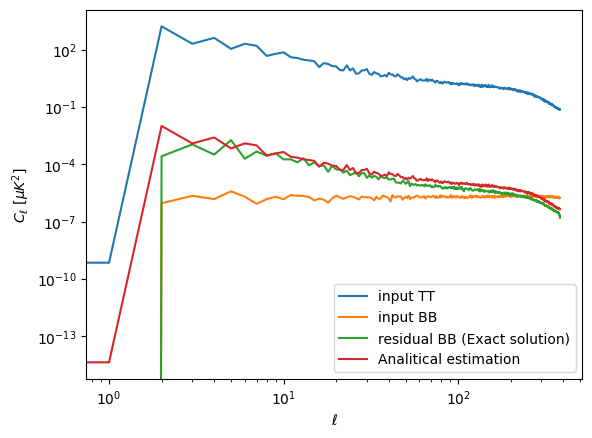

In [8]:
plt.plot(input_cl[0], label="input TT")
plt.plot(input_cl[2], label="input BB")
plt.plot(res_cl[2], label="residual BB (Exact solution)")

plt.plot(input_cl[0] * np.abs(scan_field.get_xlink(2)).mean()**2 * delta_g**2, label="Analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();

# 3x3 matrix reconstruction

So far, map-make has been carried out with a 2x2 matrix from the point of view of differential signal analysis, but we will check what happens to the systematic error by explicitly reconstructing the temperature as well.


In [9]:
output_map = scan_field.map_make(signal_field, mdim=3)
residual = input_map - output_map

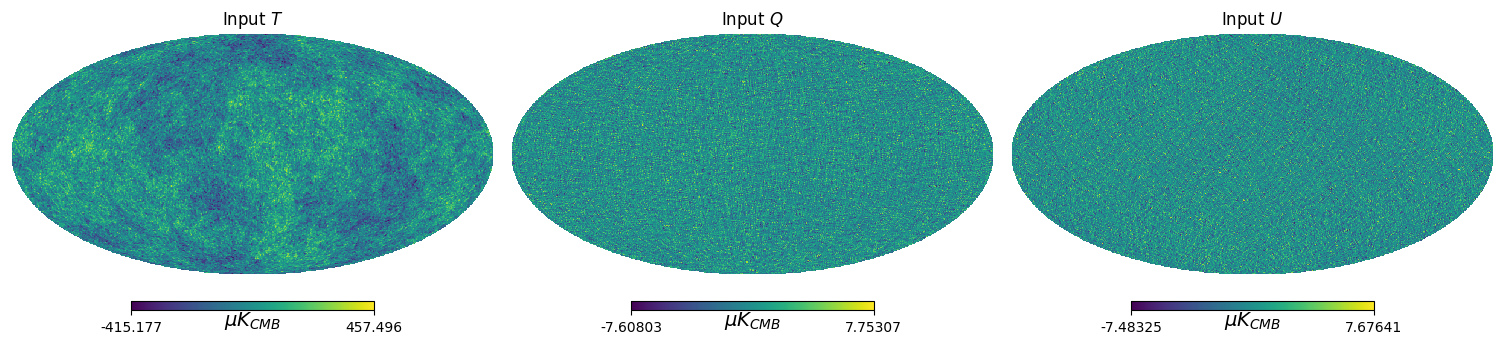

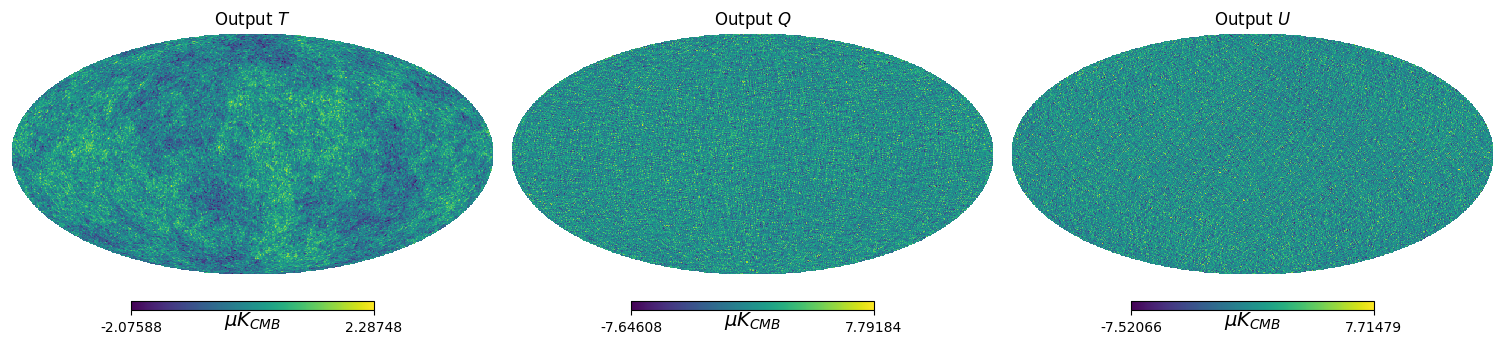

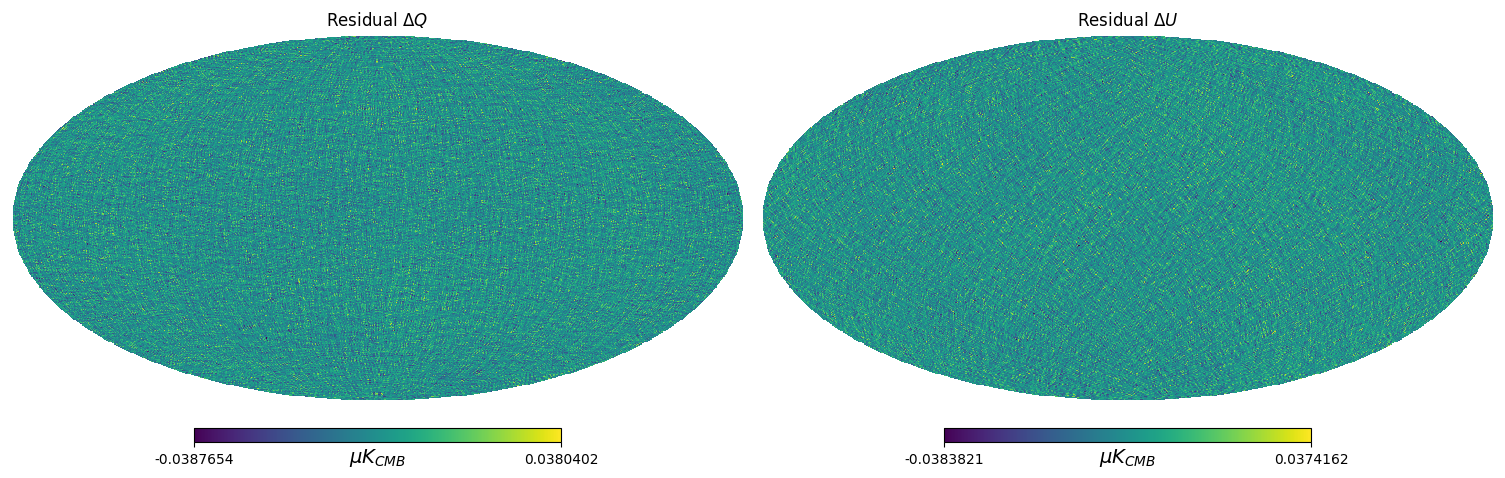

In [10]:
plt.figure(figsize=(15,5))
hp.mollview(input_map[0], sub=(1,3,1), title="Input $T$", unit="$\mu K_{CMB}$")
hp.mollview(input_map[1], sub=(1,3,2), title="Input $Q$", unit="$\mu K_{CMB}$")
hp.mollview(input_map[2], sub=(1,3,3), title="Input $U$", unit="$\mu K_{CMB}$")

plt.figure(figsize=(15,5))
hp.mollview(output_map[0], sub=(1,3,1), title="Output $T$", unit="$\mu K_{CMB}$")
hp.mollview(output_map[1], sub=(1,3,2), title="Output $Q$", unit="$\mu K_{CMB}$")
hp.mollview(output_map[2], sub=(1,3,3), title="Output $U$", unit="$\mu K_{CMB}$")

plt.figure(figsize=(15,5))
hp.mollview(residual[1], sub=(1,2,1), title="Residual $\Delta Q$", unit="$\mu K_{CMB}$")
hp.mollview(residual[2], sub=(1,2,2), title="Residual $\Delta U$", unit="$\mu K_{CMB}$")

It can be seen that the systematic error is smaller thanks to the disappearance of leakage from the temperature.

The transfer function for the $\Delta C_\ell^{BB}$ is give by

$$
\Delta C_{\ell, Ana}^{BB} = C_{\ell}^{TT} \left(\frac{\Delta g}{2}\right)^2
$$


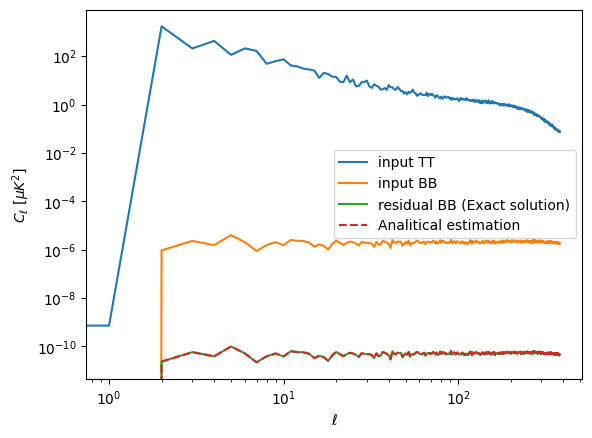

In [11]:
res_cl = hp.anafast(residual)

plt.plot(input_cl[0], label="input TT")
plt.plot(input_cl[2], label="input BB")
plt.plot(res_cl[2], label="residual BB (Exact solution)")

plt.plot(input_cl[2] * (delta_g/2)**2, "--", label="Analitical estimation")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell ~ [\mu K^2]$")
plt.xscale("log")
plt.yscale("log")
plt.legend();